In [1]:
import torch

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

In [3]:
import torchvision.models as models
import torch.nn as nn

In [4]:
# Data augmentation
transform = transforms.Compose([ # ETL process
    transforms.Resize((224, 224)), # Transforms images' resolutions to 224x224 pixels
    transforms.ToTensor(), # Converts to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # Normalizes for future training
                         std=[0.229, 0.224, 0.225]) # normalized_pixel = (pixel - mean) / std
])

dataset = datasets.ImageFolder("data/phones/dataset", transform=transform)
# ImageFolder finds 'subfolders' and assigns labels automatically
print(dataset.classes)

['good', 'oil', 'scratch', 'stain']


In [5]:
class_names = dataset.classes

In [6]:
# Dataset split
train_ratio = 0.7
val_ratio   = 0.15
test_ratio  = 0.15

total_size = len(dataset)
train_size = int(train_ratio * total_size)
val_size   = int(val_ratio * total_size)
test_size  = total_size - train_size - val_size
# Random split
train_dataset, val_dataset, test_dataset = random_split(
    dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # reproducible (i.e. every run produces the same train/val/test split)
)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:
# Training augmentation
train_dataset.dataset.transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # randomly flips image left/right
    transforms.RandomRotation(10), # randomly rotates ±10 degrees
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_dataset.dataset.transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [4]:
model = models.resnet18(pretrained=True) # pretrained convolutional neural network ResNet-18

# [IMAGE] > [CONV LAYERS] > [FEATURE VECTOR] > [FINAL LAYER] > [OUTPUT]
# Here [CONV LAYERS] and [FEATURE VECTOR] are pretrained in RosNet18
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 4)  # 4 classes
# Here [FINAL LAYER] is replaced

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# For this project laptop with integrated GPU is used, therefore the training will be performed by CPU
model = model.to(device)

C:\Users\steph\anaconda3\envs\pytorch_cpu\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\steph\anaconda3\envs\pytorch_cpu\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
criterion = nn.CrossEntropyLoss() # CrossEntropy loss function is used because there is multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=.0001)

In [10]:
def train_one_epoch(model, loader): # training of one epoch
    model.train() # model is set to a training mode
    running_loss = 0 # keeps track of cumulative loss over the epoch

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device) # moves tensors to CPU

        optimizer.zero_grad() # clears old gradients before computing new ones
        outputs = model(images) # outputs are next: [good, oil, scratch, stain]
        loss = criterion(outputs, labels) # CrossEntropy. Compares predicted logits vs true labels
        loss.backward() # computes gradients of the loss with respect to all trainable weights
        optimizer.step() # adjusts the weights using the gradients computed in the backward pass

        running_loss += loss.item() # accumulate to calculate average loss per batch later

    return running_loss / len(loader) # computes mean loss over all batches in the epoch

In [11]:
def validate(model, loader):
    model.eval() # model is set to an eval mode
    correct = 0
    total = 0

    with torch.no_grad(): # no gradients are needed during validation
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device) # moves tensors to CPU
            outputs = model(images) # outputs are next: [good, oil, scratch, stain]
            _, preds = torch.max(outputs, 1)
            # chooses one output e.g. chooses max (in this exaple 'good') from [2.1, 0.2, 0.3, -0.3]
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total # returns fraction of images correctly classified

In [12]:
epochs = 3
# I chose 3 epochs because the training on CPU is slow, also metadata shows 99% accuracy on validation data

for epoch in range(epochs):
    loss = train_one_epoch(model, train_loader)
    acc = validate(model, val_loader)

    print(f"Epoch {epoch+1}/{epochs} | Loss: {loss:.4f} | Val Acc: {acc:.4f}")

Epoch 1/3 | Loss: 0.3144 | Val Acc: 0.9891
Epoch 2/3 | Loss: 0.0295 | Val Acc: 0.9945
Epoch 3/3 | Loss: 0.0100 | Val Acc: 0.9945


In [26]:
torch.save({ # saves trained model
    "model_state": model.state_dict(),
    "class_names": dataset.classes
}, "model.pth")

In [9]:
# Recreate architecture
model = models.resnet18(pretrained=False)   # pretrained=False because we will load weights
model.fc = nn.Linear(model.fc.in_features, 4)  # same number of classes

# Load checkpoint
checkpoint = torch.load("model.pth")

# Load weights
model.load_state_dict(checkpoint["model_state"])

# Retrieve class names
class_names = checkpoint["class_names"]

# Set model to evaluation mode
model.eval()

# Move to device if needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

C:\Users\steph\anaconda3\envs\pytorch_cpu\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\steph\anaconda3\envs\pytorch_cpu\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\steph\AppData\Local\Temp\ipykernel_1452\2607760148.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
inference_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [11]:
model.eval()  # important: disables dropout and batchnorm updates

with torch.no_grad():
    # prediction code here
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

correct = 0
total = 0


with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images) # logits
        _, preds = torch.max(outputs, 1) # predicted class indices
        correct += (preds == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"Validation Accuracy: {accuracy*100:.2f}%")

Validation Accuracy: 99.45%


In [12]:
from PIL import Image

def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = inference_transform(image).unsqueeze(0).to(device)
    # unsqeeze adds a batch dimension, thus we pass to a model image with next dimensions [1, 3, 244, 244]

    model.eval()
    with torch.no_grad():
        outputs = model(image)
        _, pred = torch.max(outputs, 1)

    return class_names[pred.item()]

In [13]:
print(predict_image("test_phone.jpg")) # wrong

stain


In [14]:
print(predict_image("broken_phone.jpg")) # wrong as well

oil


In [18]:
val_loss = 0
criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

val_loss /= len(val_loader)
print(f"Test Loss: {val_loss:.4f}")

Validation Loss: 0.0158


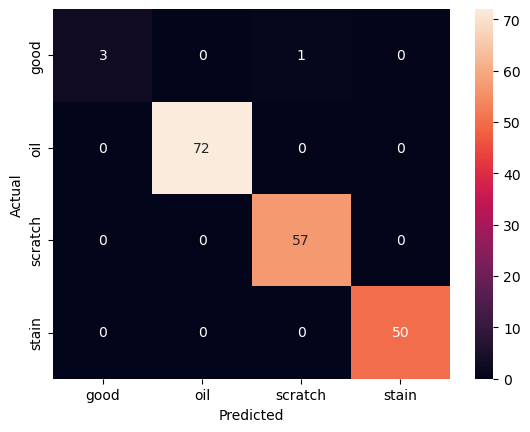

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

all_preds = []
all_labels = []
   
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy()) # converts pytorch arrays to numpy arrays and adds to a list
        all_labels.extend(labels.cpu().numpy()) # converts pytorch arrays to numpy arrays and adds to a list

cm = confusion_matrix(all_labels, all_preds) # creates 4x4 confusion matrix
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()